# Sandbox Skript

## Generate Paths

In [8]:
from src.data.make_dataset import DataLoader
from esig import tosig
from BuehlerVAE.src.utils.leadlag import leadlag
import BuehlerVAE.src.logsig_inversion as logsig_inversion
import matplotlib.pyplot as plt
import numpy as np
import torch

In [9]:
# Specify the data loader parameters
n = 10
dt = 1/20
nPeriods = 1.
brownian_motion_params = {
    "T": nPeriods, 
    "dt": dt, 
    "n": n
}
gbm_params = {
    "S0": 1., 
    "mu": 0.05,
    "sigma": 0.2, 
    "T": nPeriods, 
    "dt": dt, 
    "n": n
}
kou_params = {
    "S0": 1., 
    "mu": 0.15, 
    "sigma": 0.2, 
    "lambda_": 2.0, 
    "p": 0.3, 
    "eta1": 50., 
    "eta2": 25., 
    "T": nPeriods, 
    "dt": dt, 
    "n": n
}

In [10]:
bm_loader = DataLoader(method="Brownian_Motion", params=brownian_motion_params)
gbm_loader = DataLoader(method="GBM", params=gbm_params)
kou_loader = DataLoader(method="Kou_Jump_Diffusion", params=kou_params)
pathsBM, timesBM = bm_loader.create_dataset(output_type="np.ndarray")
# print(paths1.shape)
pathsGBM, timesGBM = gbm_loader.create_dataset(output_type="np.ndarray")
# print(paths2.shape)
pathsKOU, timesKOU = kou_loader.create_dataset(output_type="np.ndarray")
# print(paths.shape)

In [11]:
# Select paths to analyze
paths = pathsKOU
times = timesKOU

## Signature and Signature inversion 

In [12]:
import signatory as sg
from src.features.data_transformer import Transformer
# convert paths to torch tensor for signatory library
paths_torch = Transformer().arrays_to_torch_tensor(times, paths)
# set the depth of the signature (or order) 
# if granularity equals depth, output will be of same format as input
depth = int(nPeriods/dt)
signatures = sg.signature(paths_torch, depth)
inverted_paths = sg.invert_signature(signatures, depth=depth, channels=2, initial_position=paths_torch[:, 0, :])

times_recovered, paths_recovered = Transformer().torch_tensor_to_arrays(inverted_paths)

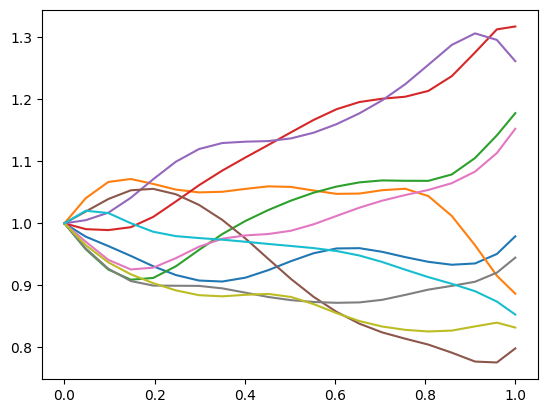

In [13]:
# paths are smoothened by the signature transformation
plt.plot(times_recovered, paths_recovered)
plt.show()

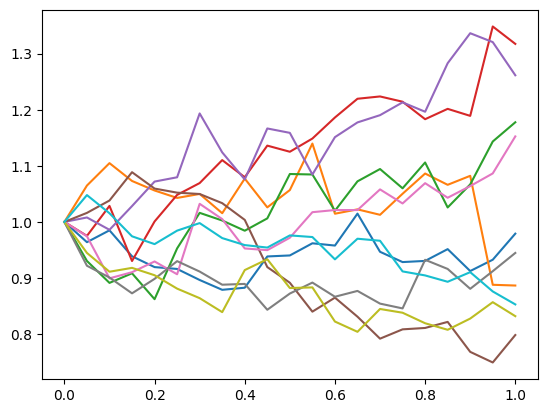

In [14]:
plt.plot(times, paths)
plt.show()

In [24]:
# Compute log-signature
path = paths[:,0]
order = 4
leadlag_path = leadlag(path)
logsig = tosig.stream2logsig(leadlag_path, order)
# normal log-sig:
print(sg.logsignature(paths_torch, order)[0,:].numpy())
# leadlag log-sig:
print(f"Leadlag Log-signature:\n {logsig}")

[ 1.00000000e+00 -2.09351301e-02  5.02244738e-02 -1.83322216e-03
  1.72059047e-03 -3.41319580e-04 -1.40726844e-04  4.41919112e-05]
Leadlag Log-signature:
 [-2.09351301e-02 -2.09351301e-02 -1.06629330e-02  3.48815010e-04
  3.57497064e-04 -1.18995539e-05 -2.01336116e-05 -1.05739731e-05]


In [ ]:
n_iterations = 100
n_organisms = 1000
recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, path.shape[0],
                                              0.01, 10)

In [ ]:
plt.plot(recovered_path)
# next: Check leadlag
plt.plot(path-1)
plt.show()
print(f"Real log-signature: {logsig}")
print(f"Recovered log-signature: {tosig.stream2logsig(leadlag(recovered_path), order)}")